# Definiowanie bibliotek symulacji

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.optimize as optimize
import pickle

# Definiowanie parametrów symulacji

In [2]:
num_11 = 1.2
den_11 = [10, 1]
coefficients_11 = (num_11, den_11)

num_12 = 0.6
den_12 = [30, 1]
coefficients_12 = (num_12, den_12)

num_21 = 0.5
den_21 = [20, 1]
coefficients_21 = (num_21, den_21)

num_22 = 1.5
den_22 = [15, 1]
coefficients_22 = (num_22, den_22)

In [3]:
A_11, B_11, C_11, D_11 = signal.tf2ss(num_11, den_11)
A_12, B_12, C_12, D_12 = signal.tf2ss(num_12, den_12)
A_21, B_21, C_21, D_21 = signal.tf2ss(num_21, den_21)
A_22, B_22, C_22, D_22 = signal.tf2ss(num_22, den_22)

In [4]:
sys_11 = signal.StateSpace(A_11, B_11, C_11, D_11)
dsys_11 = sys_11.to_discrete(0.1)
sys_12 = signal.StateSpace(A_12, B_12, C_12, D_12)
dsys_12 = sys_12.to_discrete(0.1)
sys_21 = signal.StateSpace(A_21, B_21, C_21, D_21)
dsys_21 = sys_21.to_discrete(0.1)
sys_22 = signal.StateSpace(A_22, B_22, C_22, D_22)
dsys_22 = sys_22.to_discrete(0.1)

# Definiowanie klasy do znajdowania wejścia z wyjścia

In [5]:
class ComputeInputsFromOutput:
    bnds = [(-100, 100)]
    def __init__(self, sys, power):
        self.sys = sys
        self.power = power
        self.resetState()
        
    def resetState(self):
        self.state = np.array([[0]])
        
    def findModelInputs(self, e):
        self.resetState()
        r = []
        steps = e.shape[0]
        for index in range(steps):
            if(index < (steps - 1)):
                state = self.state
                output = e[index+1]
            
                res = optimize.differential_evolution(self.error, args=(state, output), polish=False, 
                                                      bounds=self.bnds, workers=1, maxiter=500, tol=1e-26)
                r.append(res.x[0])
#                 print('Param number: {}, Number iter: {}, error: {}'.format(index,res.nit,res.fun))
        r.append(r[-1])
        return np.asarray(r)
    
    def error(self, x, state, output):
        y = self.transferFunctionNextOutput(state, x)
        e = np.abs(y-output)
        return e
    
    def transferFunctionNextOutput(self, state, inputs):
        self.state = self.sys.A*state + self.sys.B*inputs
        next_output = self.sys.C*self.state
        return np.float_power(next_output, self.power)

# Definiowanie klasy do symulacji obiektu pętla otwarta

In [6]:
class NonlinearTitoObject:
    def __init__(self, coefficients_11, coefficients_12, coefficients_21, coefficients_22, start, stop, steps):
        self.p_11 = signal.TransferFunction(coefficients_11[0], coefficients_11[1])
        self.p_12 = signal.TransferFunction(coefficients_12[0], coefficients_12[1])
        self.p_21 = signal.TransferFunction(coefficients_21[0], coefficients_21[1])
        self.p_22 = signal.TransferFunction(coefficients_22[0], coefficients_22[1])
        self.steps = steps
        self.time = np.linspace(start, stop, steps)
        self.time_up_limit = int(steps/2*0.75)
        self.time_low_limit = int(steps/2*1.25)
    
    def coeffinOutputNonlinear(self, non_out_11, non_out_12, non_out_21, non_out_22):
        self.non_out_11 = non_out_11
        self.non_out_12 = non_out_12
        self.non_out_21 = non_out_21
        self.non_out_22 = non_out_22
        
    def inputRange(self, start, stop, num):
        self.input_range = np.linspace(start, stop, num)
    
    def output(self, u1, u2):#, t=self.time):
        _, temp_y_11, _ = signal.lsim2(self.p_11, u1, self.time)
        _, temp_y_12, _ = signal.lsim2(self.p_12, u2, self.time)
        _, temp_y_21, _ = signal.lsim2(self.p_21, u1, self.time)
        _, temp_y_22, _ = signal.lsim2(self.p_22, u2, self.time)
        
        y_11 = np.float_power(temp_y_11, self.non_out_11)
        y_12 = np.float_power(temp_y_12, self.non_out_12)
        y_21 = np.float_power(temp_y_21, self.non_out_21)
        y_22 = np.float_power(temp_y_22, self.non_out_22)
        
        y1 = y_11 + y_12
        y2 = y_22 + y_21
        
        return y1, y2
    
    def randInputs(self):
        u1 = np.ones_like(self.time)*np.random.choice(self.input_range)
        u1[:np.random.randint(0,self.time_up_limit)] = 0
        u1[np.random.randint(self.time_low_limit,self.steps):self.steps] = 0
        
        u2 = np.ones_like(self.time)*np.random.choice(self.input_range)
        u2[:np.random.randint(0,self.time_up_limit)] = 0
        u2[np.random.randint(self.time_low_limit,self.steps):self.steps] = 0
        
        return u1, u2
    
    def nextBatch(self):
        u1, u2 = self.randInputs()
        y1, y2 = self.output(temp_input_1, temp_input_2)
        return temp_input_1, temp_input_2, y1, y2
    
    def takeCorectModelOutputs(self):
        u1, u2 = self.randInputs()
        y1, _ = self.output(u1, np.zeros_like(u1))
        _, y2 = self.output(np.zeros_like(u2), u2)
        return u1, u2, y1, y2
    
    def takeErrors(self, u1, u2):
        u0 = np.zeros_like(u1)
        e1, _ = self.output(u0, u2)
        _, e2 = self.output(u1, u0)
        return e1, e2

# Tworzenie obiektów klas

In [7]:
computeInputP11 = ComputeInputsFromOutput(dsys_11, 3)
computeInputP22 = ComputeInputsFromOutput(dsys_22, 3)
nonlin_TITO = NonlinearTitoObject(coefficients_11, coefficients_12,
                                  coefficients_21, coefficients_22,
                                  0, 30, 301)
nonlin_TITO.coeffinOutputNonlinear(3, 3, 3, 3)
nonlin_TITO.inputRange(0, 2, 21)

# Importowanie bibliotek do sieci neuronowych

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, SimpleRNN, TimeDistributed, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

# Definiowanie struktur sieci

In [9]:
def basic_model(batch_size):
    if(batch_size<=1):
        stateful = True
    else:
        stateful = False
    x = Input(shape=(batch_size, 1), batch_size=1)
    y = LSTM(32, return_sequences=True, stateful=stateful)(x)
    y = Dense(16)(y)
    y = Dense(16)(y)
    y = Dense(1)(y)
    return Model(x, y)

def advance_model(batch_size):
    if(batch_size<=1):
        stateful = True
    else:
        stateful = False
    x = Input(shape=(batch_size, 1), batch_size=1)
    y = LSTM(32, return_sequences=True, stateful=stateful)(x)
    y = LSTM(32, return_sequences=True, stateful=stateful)(x)
    y = Dense(16)(y)
    y = Dense(16)(y)
    y = Dense(16)(y)
    y = Dense(1)(y)
    return Model(x, y)

# Tworzenie modelów do trenowania

In [10]:
model_12_train = basic_model(301)
model_21_train = basic_model(301)

# Załadowywanie współczynników sieci

In [12]:
model_12_train.load_weights('model_12_train.h5')
model_21_train.load_weights('model_21_train.h5')

# Kompilowanie sieci

In [13]:
model_12_train.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
model_21_train.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

# Definiowanie list z danymi do trenowania

In [14]:
u1_data = []
u2_data = []
r1_data = []
r2_data = []

# Wczytywanie list do trenowania

In [15]:
file = open('u1_u2_r1_r2_data', 'rb')
u1_data, u2_data, r1_data, r2_data = pickle.load(file)
file.close()

# Trenowanie sieci

In [ ]:
epochs = 1000
for i in range(epochs):
    u1, u2 = nonlin_TITO.randInputs()
    e1, e2 = nonlin_TITO.takeErrors(u1, u2)
    r1 = computeInputP11.findModelInputs(e1*-1)
    r2 = computeInputP22.findModelInputs(e2*-1)
    u1 = np.reshape(u1,(1,u1.shape[0],1))
    u2 = np.reshape(u2,(1,u2.shape[0],1))
    r1 = np.reshape(r1,(1,r1.shape[0],1))
    r2 = np.reshape(r2,(1,r2.shape[0],1))
    u1_data.append(u1)
    u2_data.append(u2)
    r1_data.append(r1)
    r2_data.append(r2)
    history_21 = model_21_train.fit(u1, r2, epochs=8, batch_size=1, verbose=0)
    history_12 = model_12_train.fit(u2, r1, epochs=8, batch_size=1, verbose=0)
    print('Epoch: {}'.format(i+1

In [ ]:
history_21 = model_21_train.fit(u1_data, r2_data, epochs=2000, batch_size=1, verbose=1)

In [ ]:
history_12 = model_12_train.fit(u2_data, r1_data, epochs=2000, batch_size=1, verbose=1)

# Przykładowy wynik wytrenowania sieci

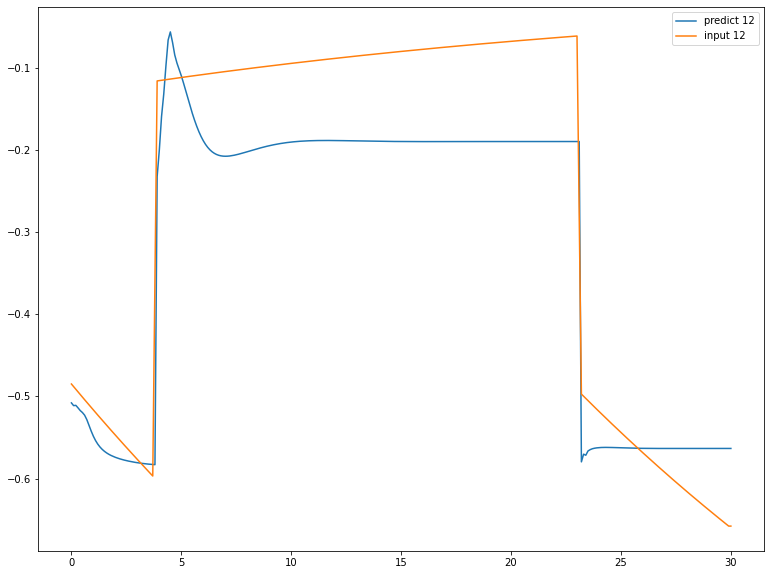

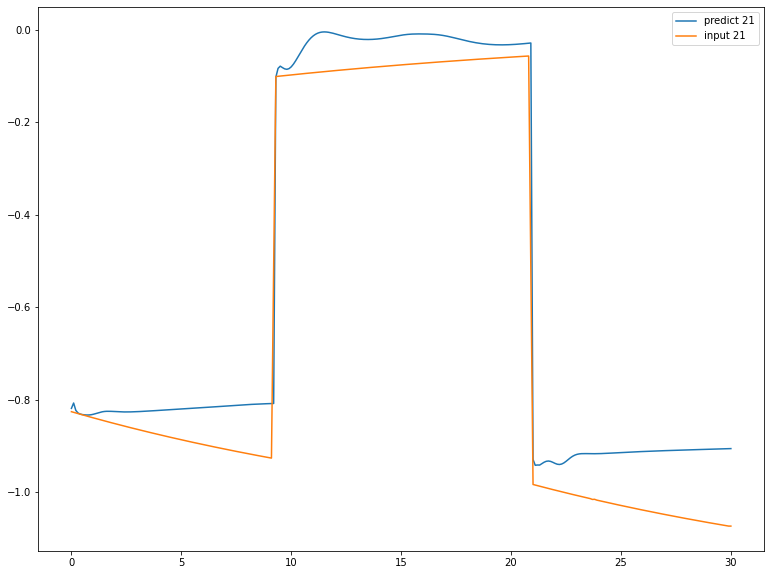

In [21]:
t = np.linspace(0,30,301)
index = -20

testPredict12 = model_12_train.predict(u2_data[index])
testPredict21 = model_21_train.predict(u1_data[index])

plt.figure(figsize=(13,10))
plt.plot(t, testPredict12.reshape(testPredict12.shape[1]), label='predict 12')
plt.plot(t, r1_data[index].reshape(r1_data[index].shape[1]), label='input 12')
plt.legend()

plt.figure(figsize=(13,10))
plt.plot(t, testPredict21.reshape(testPredict21.shape[1]), label='predict 21')
plt.plot(t, r2_data[index].reshape(r2_data[index].shape[1]), label='input 21')
plt.legend()

# Zapisywanie wytrenowanego modelu

In [327]:
model_12_train.save_weights('model_12_train.h5')
model_21_train.save_weights('model_21_train.h5')

# Zapisywanie danych do trenowania

In [ ]:
file = open('u1_u2_r1_r2_data', 'wb')
pickle.dump([u1_data, u2_data, r1_data, r2_data], file)
file.close()

# Definiowanie modelów do symulacji

In [22]:
model_12_sym = basic_model(1)
model_21_sym = basic_model(1)

# Załadowanie wytrenowanych współczynników do modelów symulacji

In [23]:
model_12_train.load_weights('model_12_train.h5')
model_21_train.load_weights('model_21_train.h5')

# Klasa modelu dyskretnego

In [24]:
class DiscreateNonlinModel:

# --------------------------------------    
    def __init__(self, dsys_11, dsys_12, dsys_21, dsys_22):
        self.A_11 = dsys_11.A
        self.A_12 = dsys_12.A
        self.A_21 = dsys_21.A
        self.A_22 = dsys_22.A
        
        self.B_11 = dsys_11.B
        self.B_12 = dsys_12.B
        self.B_21 = dsys_21.B
        self.B_22 = dsys_22.B
        
        self.C_11 = dsys_11.C
        self.C_12 = dsys_12.C
        self.C_21 = dsys_21.C
        self.C_22 = dsys_22.C
        
        self.resetState()
        
    def resetState(self):
        self.x_11 = np.array([[0]])
        self.x_12 = np.array([[0]])
        self.x_21 = np.array([[0]])
        self.x_22 = np.array([[0]])
        
    def output(self, u1, u2):
        self.resetState()
        steps = u1.shape[0]
        y1 = []
        y2 = []
        
        temp_y1, temp_y2 = self.zeroOutputs([self.x_11, self.x_12, self.x_21, self.x_22])
        y1.append(temp_y1)
        y2.append(temp_y2)

        for index in range(steps):
            if(index < (steps - 1)):
                temp_y1, temp_y2 = self.y_NextOutputs([self.x_11, self.x_12, self.x_21, self.x_22],
                                                      [u1[index], u2[index]])
                y1.append(temp_y1)
                y2.append(temp_y2)
        
        y1 = np.asarray(y1)
        y1 = y1.reshape(y1.shape[0])
        y2 = np.asarray(y2)
        y2 = y2.reshape(y2.shape[0])
        return y1, y2   
        
    def outputFeedback(self, u1, u2):
        self.resetState()
        steps = u1.shape[0]
        y1 = []
        y2 = []
        r1 = []
        r2 = []
        
        temp_y1, temp_y2 = self.zeroOutputs([self.x_11, self.x_12, self.x_21, self.x_22])
        y1.append(temp_y1)
        y2.append(temp_y2)
        
        last_y1 = 0.0
        last_y2 = 0.0
        for index in range(steps):
            if(index == 0):
                r1.append(u1[index])
                r2.append(u2[index])
            if(index < (steps - 1)):
                temp_r1 = u1[index]-last_y1
                temp_r2 = u2[index]-last_y2
                temp_y1, temp_y2 = self.y_NextOutputs([self.x_11, self.x_12, self.x_21, self.x_22],
                                                      [temp_r1, temp_r2])
                y1.append(temp_y1)
                y2.append(temp_y2)
                last_y1 = temp_y1
                last_y2 = temp_y2
                r1.append(np.float(temp_r1))
                r2.append(np.float(temp_r2))
            
        
        y1 = np.asarray(y1)
        y1 = y1.reshape(y1.shape[0])
        y2 = np.asarray(y2)
        y2 = y2.reshape(y2.shape[0])
        r1 = np.asarray(r1)
        r1 = r1.reshape(r1.shape[0])
        r2 = np.asarray(r2)
        r2 = r2.reshape(r2.shape[0])
        return y1, y2, r1, r2
    
    def outputFeedbackRNNDecouple(self, u1, u2):
        self.resetState()
        steps = u1.shape[0]
        y1 = []
        y2 = []
        
        temp_y1, temp_y2 = self.zeroOutputs([self.x_11, self.x_12, self.x_21, self.x_22])
        y1.append(temp_y1)
        y2.append(temp_y2)
        
        self.decouple_NN_12.reset_states()
        self.decouple_NN_21.reset_states()
        
        last_y1 = 0.0
        last_y2 = 0.0
        for index in range(steps):
            if(index < (steps - 1)):
                r1 = u1[index]-last_y1 + np.float(self.decouple_NN_12.predict((u2[index]-last_y2).reshape(1,1,1)))
                r2 = u2[index]-last_y2 + np.float(self.decouple_NN_21.predict((u1[index]-last_y1).reshape(1,1,1)))
                temp_y1, temp_y2 = self.y_NextOutputs([self.x_11, self.x_12, self.x_21, self.x_22],
                                                      [r1, r2])
                y1.append(temp_y1)
                y2.append(temp_y2)
                last_y1 = temp_y1
                last_y2 = temp_y2
            print('Step: {}'.format(index))
        
        y1 = np.asarray(y1)
        y1 = y1.reshape(y1.shape[0])
        y2 = np.asarray(y2)
        y2 = y2.reshape(y2.shape[0])
        return y1, y2
    
    def addDecoupeRNNModel(self, decouple_NN_12, decouple_NN_21):
        self.decouple_NN_12 = decouple_NN_12
        self.decouple_NN_21 = decouple_NN_21
        
    def takeErrors(self, u1, u2):
        u0 = np.zeros_like(u1)
        print(u0.shape)
        print(u0)
        e1 = self.output(u0, u2)
        e2 = self.output(u1, u0)
        return r1, r2
    
# --------------------------------------

    def y_NextOutputs(self, states, inputs):
        y1 = self.y1_NextOutput([states[0],states[1]], inputs)
        y2 = self.y2_NextOutput([states[2],states[3]], inputs)
        return y1, y2
    
    def y1_NextOutput(self, states, inputs):
        y_p11 = self.p11_NextOutput(states[0], inputs[0])
        y_p12 = self.p12_NextOutput(states[1], inputs[1])
        return y_p11 + y_p12

    def y2_NextOutput(self, states, inputs):
        y_p21 = self.p21_NextOutput(states[0], inputs[0])
        y_p22 = self.p22_NextOutput(states[1], inputs[1])
        return y_p22 + y_p21
    
    def zeroOutputs(self, states):
        zero_p_11_output = self.C_11*states[0]
        zero_p_12_output = self.C_12*states[1]
        zero_p_21_output = self.C_21*states[2]
        zero_p_22_output = self.C_22*states[3]
        
        zero_p_11_output = zero_p_11_output**3
        zero_p_12_output = zero_p_12_output**3
        zero_p_21_output = zero_p_21_output**3
        zero_p_22_output = zero_p_22_output**3
        
        y1 = zero_p_11_output + zero_p_12_output
        y2 = zero_p_22_output + zero_p_21_output
        
        return y1, y2

# --------------------------------------
    
    def p11_NextOutput(self, state, inputs):
        self.x_11 = self.A_11*state + self.B_11*inputs
        next_output = self.C_11*self.x_11
        return np.power(next_output, 3)
    
    def p12_NextOutput(self, state, inputs):
        self.x_12 = self.A_12*state + self.B_12*inputs
        next_output = self.C_12*self.x_12
        return np.power(next_output, 3)

    def p21_NextOutput(self, state, inputs):
        self.x_21 = self.A_21*state + self.B_21*inputs
        next_output = self.C_21*self.x_21
        return np.power(next_output, 3)

    def p22_NextOutput(self, state, inputs):
        self.x_22 = self.A_22*state + self.B_22*inputs
        next_output = self.C_22*self.x_22
        return np.power(next_output, 3)

# Tworzenie dyskretnego obiektu modelu

In [25]:
dnonlin_TITO = DiscreateNonlinModel(dsys_11, dsys_12,
                                  dsys_21, dsys_22)

# Definiowanie parametrów symulacji

In [74]:
u1 = np.zeros(1001)
u2 = np.zeros(1001)

In [75]:
t = np.linspace(0,100,1001)
u1[0:801] = 3
u2[400:] = 2

# Symulacja pętla otwarta

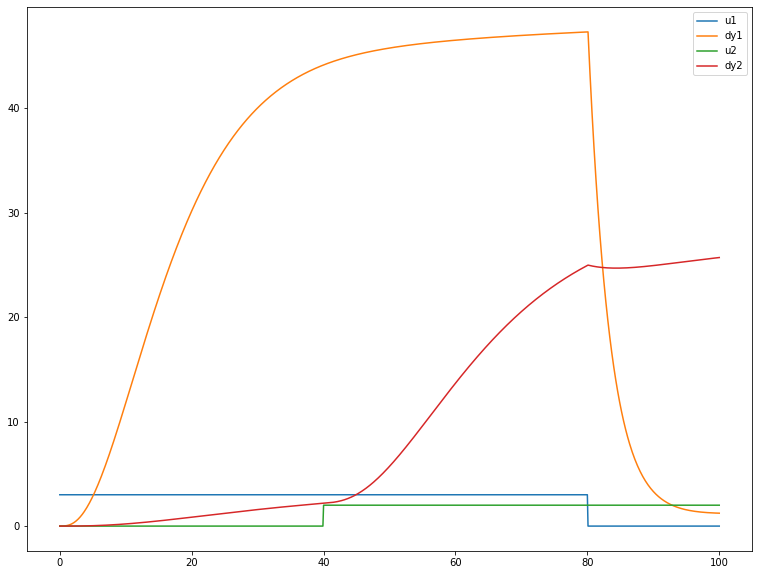

In [28]:
dnonlin_y1, dnonlin_y2 = dnonlin_TITO.output(u1, u2)
plt.figure(figsize=(13,10))
plt.plot(t, u1, label='u1')
plt.plot(t, dnonlin_y1, label='dy1')
plt.plot(t, u2, label='u2')
plt.plot(t, dnonlin_y2, label='dy2')
plt.legend()

# Symulacja ze sprzężeniem zwrotnym

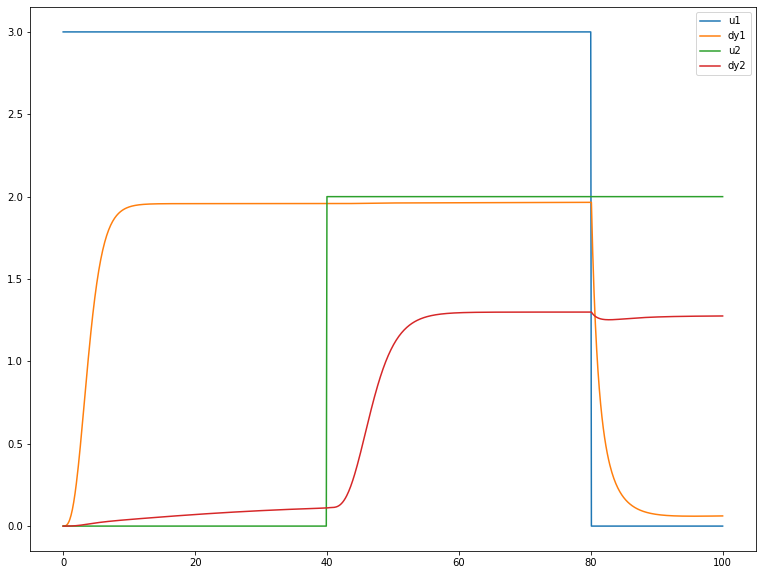

In [29]:
dnonlin_feedback_y1, dnonlin_feedback_y2, test_r1, test_r2 = dnonlin_TITO.outputFeedback(u1, u2)
plt.figure(figsize=(13,10))
plt.plot(t, u1, label='u1')
plt.plot(t, dnonlin_feedback_y1, label='dy1')
plt.plot(t, u2, label='u2')
plt.plot(t, dnonlin_feedback_y2, label='dy2')
plt.legend()

# Symulacja z odsprzęganiem sieciami neuronowymi

In [30]:
dnonlin_TITO.addDecoupeRNNModel(model_12_sym, model_21_sym)

In [ ]:
dnonlin_decoupleRNN_y1, dnonlin_decoupleRNN_y2 = dnonlin_TITO.outputFeedbackRNNDecouple(u1, u2)

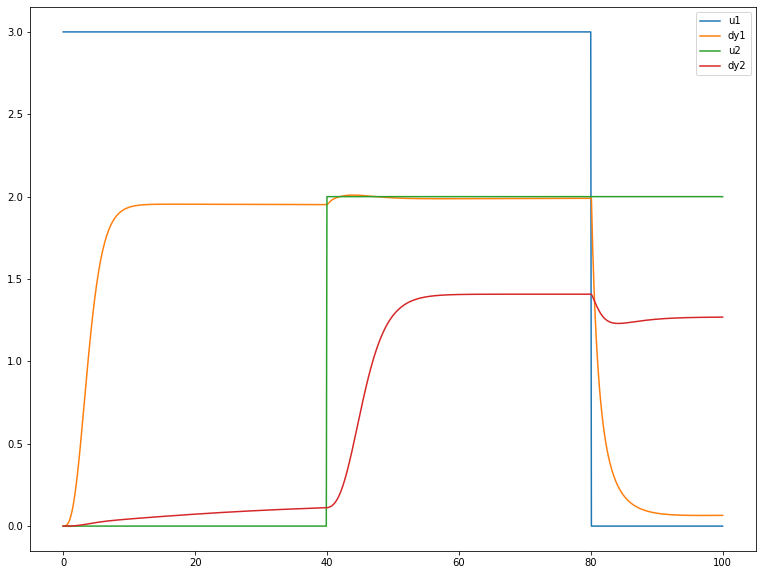

In [32]:
plt.figure(figsize=(13,10))
plt.plot(t, u1, label='u1')
plt.plot(t, dnonlin_decoupleRNN_y1, label='dy1')
plt.plot(t, u2, label='u2')
plt.plot(t, dnonlin_decoupleRNN_y2, label='dy2')
plt.legend()

# Przeliczanie wcześniejszych danych treningowych na ze sprzężeniem zwrotnym

In [33]:
u1_data_feedback = []
u2_data_feedback = []
r1_data_feedback = []
r2_data_feedback = []

In [311]:
def computeInputForFeedback(u1, u2, dnonlin_TITO, nonlin_TITO):
    _, _, temp_u1_feedback, temp_u2_feedback = dnonlin_TITO.outputFeedback(u1.reshape(u1.shape[1]), u2.reshape(u2.shape[1]))
    e1, e2 = nonlin_TITO.takeErrors(temp_u1_feedback, temp_u2_feedback)
    temp_r1 = computeInputP11.findModelInputs(e1*-1)
    temp_r2 = computeInputP22.findModelInputs(e2*-1)
    u1_data_feedback = temp_u1_feedback
    u2_data_feedback = temp_u2_feedback
    r1_data_feedback = temp_r1
    r2_data_feedback = temp_r2
    return u1_data_feedback, u2_data_feedback, r1_data_feedback, r2_data_feedback

In [ ]:
for index, _ in enumerate(u1_data):
    u1_d_f, u2_d_f, r1_d_f, r2_d_f = computeInputForFeedback(u1_data[index], u2_data[index], dnonlin_TITO, nonlin_TITO)
    u1_data_feedback.append(u1_d_f)
    u2_data_feedback.append(u2_d_f)
    r1_data_feedback.append(r1_d_f)
    r2_data_feedback.append(r2_d_f)
    print(index)

In [70]:
for index, _ in enumerate(u1_data):
    u1_data_feedback[index] = u1_data_feedback[index].reshape(1, u1_data_feedback[index].shape[0], 1)
    u2_data_feedback[index] = u2_data_feedback[index].reshape(1, u2_data_feedback[index].shape[0], 1)
    r1_data_feedback[index] = r1_data_feedback[index].reshape(1, r1_data_feedback[index].shape[0], 1)
    r2_data_feedback[index] = r2_data_feedback[index].reshape(1, r2_data_feedback[index].shape[0], 1)

# Zapisywanie danych do trenowania ze sprzężeniem zwrotnym

In [72]:
file = open('u1_u2_r1_r2_data_feedback', 'wb')
pickle.dump([u1_data_feedback, u2_data_feedback, r1_data_feedback, r2_data_feedback], file)
file.close()

# Wczytywanie danych do trenowania ze sprzężeniem zwrotnym

In [65]:
file = open('u1_u2_r1_r2_data_feedback', 'rb')
u1_data_feedback, u2_data_feedback, r1_data_feedback, r2_data_feedback = pickle.load(file)
file.close()

# Definiowanie modelu trenującego do obiektu ze sprzężenie zwrotnym

In [77]:
model_12_train_feedback = basic_model(301)
model_21_train_feedback = basic_model(301)

# Kompilowanie modelu ze sprzężeniem zwrotnym

In [78]:
model_12_train_feedback.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
model_21_train_feedback.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

In [ ]:
history_21 = model_21_train_feedback.fit(u1_data_feedback, r2_data_feedback, epochs=5000, batch_size=1, verbose=1)
history_12 = model_12_train_feedback.fit(u2_data_feedback, r1_data_feedback, epochs=5000, batch_size=1, verbose=1)

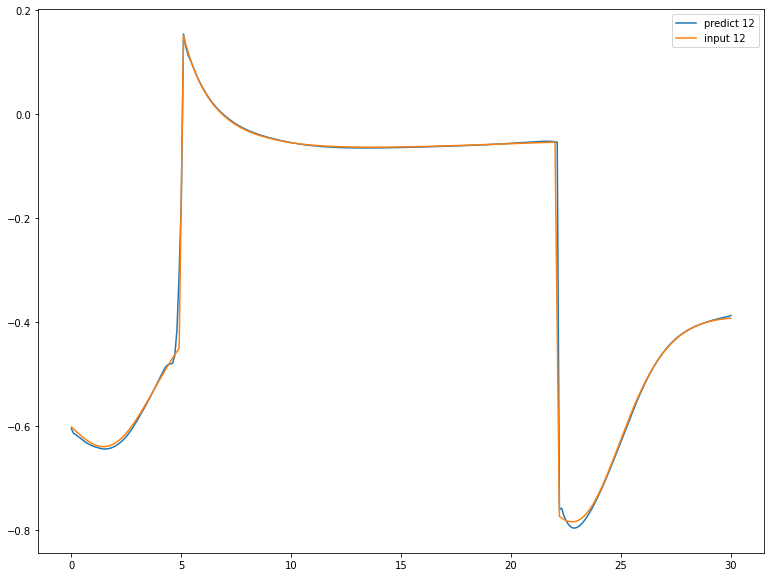

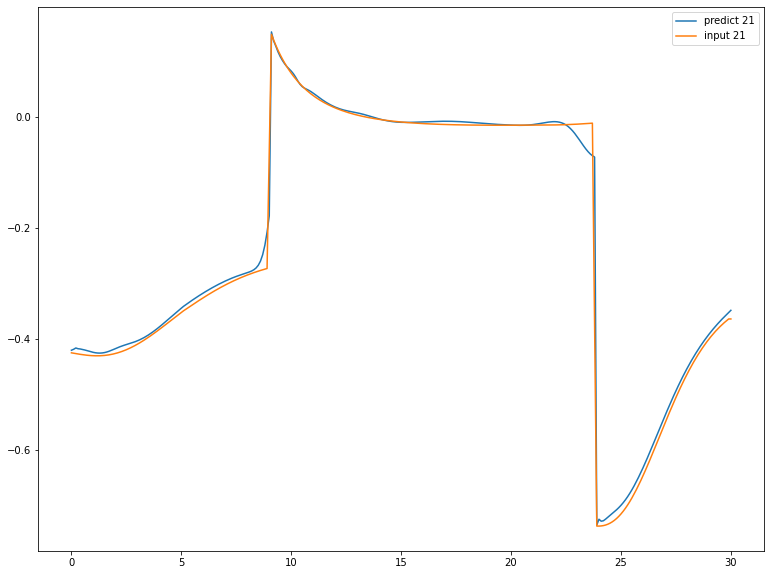

In [87]:
t = np.linspace(0,30,301)
index = 0

testPredict12 = model_12_train_feedback.predict(u2_data_feedback[index])
testPredict21 = model_21_train_feedback.predict(u1_data_feedback[index])

plt.figure(figsize=(13,10))
plt.plot(t, testPredict12.reshape(testPredict12.shape[1]), label='predict 12')
plt.plot(t, r1_data_feedback[index].reshape(r1_data_feedback[index].shape[1]), label='input 12')
plt.legend()

plt.figure(figsize=(13,10))
plt.plot(t, testPredict21.reshape(testPredict21.shape[1]), label='predict 21')
plt.plot(t, r2_data_feedback[index].reshape(r2_data_feedback[index].shape[1]), label='input 21')
plt.legend()

In [88]:
model_12_train_feedback.save_weights('model_12_train_feedback.h5')
model_21_train_feedback.save_weights('model_21_train_feedback.h5')

# Definiowanie modelów symulacji ze sprzężeniem zwrotnym

In [89]:
model_12_sym_feedback = basic_model(1)
model_21_sym_feedback = basic_model(1)

# Załadowanie wytrenowanych współczynników do modelów symulacji ze sprzężeniem zwrotnym

In [90]:
model_12_train_feedback.load_weights('model_12_train_feedback.h5')
model_21_train_feedback.load_weights('model_21_train_feedback.h5')

In [91]:
dnonlin_TITO.addDecoupeRNNModel(model_12_sym_feedback, model_21_sym_feedback)

In [ ]:
dnonlin_decoupleRNN_y1, dnonlin_decoupleRNN_y2 = dnonlin_TITO.outputFeedbackRNNDecouple(u1, u2)

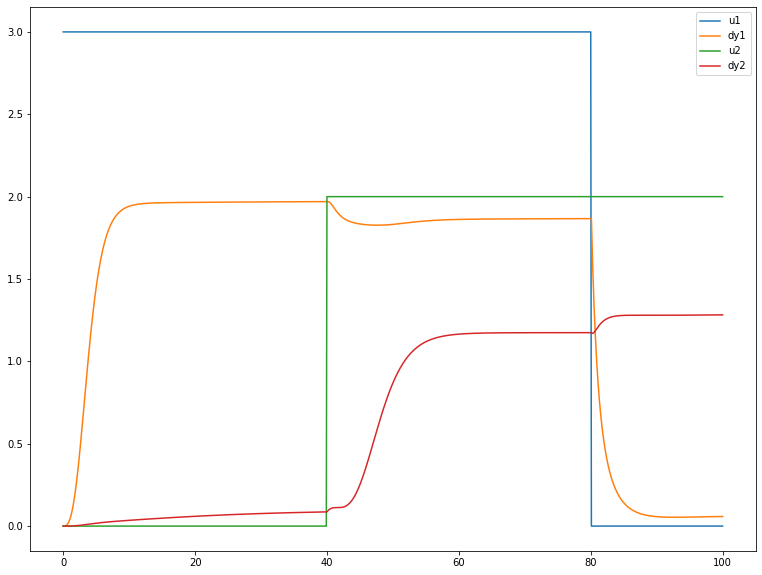

In [76]:
plt.figure(figsize=(13,10))
plt.plot(t, u1, label='u1')
plt.plot(t, dnonlin_decoupleRNN_y1, label='dy1')
plt.plot(t, u2, label='u2')
plt.plot(t, dnonlin_decoupleRNN_y2, label='dy2')
plt.legend()